# Imports

In [181]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import logging 
import csv

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import *
from keras.wrappers.scikit_learn import KerasClassifier

import random
import math
from sklearn import tree, preprocessing
from sklearn.neighbors import KNeighborsClassifier, DistanceMetric
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate, train_test_split
from sklearn.ensemble import AdaBoostClassifier
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback, CSVLogger
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC

import timeit

#from imblearn.over_sampling import RandomOverSampler

# Functions

In [2]:
def MAPE(pred,act):
    return np.mean(np.abs(pred-act)/act)*100

def Pred_correct(pred,act):
    correct = np.abs(pred-act)
    return len(correct[correct==0])/len(act)

def convert_out(data):
    output = []
    for i in range(np.shape(data)[0]):
        loc = np.where(data[i,]==max(data[i,]))[0]
        output.append(loc[0]+1)
    return(output)

def create_model_nn(neurons=1,optimizer='adam'):
# create model
    model = Sequential()
    model.add(Dense(neurons, input_dim=14, kernel_initializer='normal', activation='relu'))
    model.add(Dense(36, kernel_initializer='normal', activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

def create_model_tree():
    dtree = tree.DecisionTreeClassifier(criterion = "entropy", splitter = 'best', max_leaf_nodes = 90, min_samples_leaf = 1, max_depth=3)

    

# Preprocessing data

In [151]:
data = pd.read_csv('leaf.csv', header=None)
data.drop([1],inplace=True,axis=1)
X = data.values[:,1:]
Y_first = data.values[:,0]
Y = []
out = np.zeros(shape=[36])
for i in range(np.shape(Y_first)[0]):
    out[int(Y_first[i])-1]=1
    Y.append(out)
    out = np.zeros(shape=[36])
Y = np.array(Y)
min_max_scaler = preprocessing.MinMaxScaler()
X_scaled = min_max_scaler.fit_transform(X)
df_normalized = pd.DataFrame(X_scaled)

r,c = np.shape(df_normalized)

total_samples = list(np.arange(0,r,1))
test_samples = random.sample(total_samples,int(np.round(len(total_samples)*0.2)))
train_samples = list(set(total_samples) - set(test_samples))

# Splitting data

In [152]:
trainX = X[train_samples]
trainY = Y[train_samples]
trainY_comp = Y_first[train_samples]

testX = X[test_samples]
testY = Y[test_samples]
testY_comp = Y_first[test_samples]

# Determining optimal Number of Neurons 

In [116]:
neurons = np.arange(1,501,50)

train_e = []
test_e = []
val_acc = []
tr_acc = []

values = random.sample(list(np.arange(0,len(trainX),1)),len(trainX))
trainX_use = trainX[values,:]
trainY_use = trainY[values,:]

for i in range(len(neurons)):
    model = Sequential()
    model.add(Dense(neurons[i], input_dim=14, kernel_initializer='normal', activation='relu'))
    model.add(Dense(36, kernel_initializer='normal', activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    hist=model.fit(trainX_use,trainY_use,nb_epoch=1500, batch_size=40,verbose=0)
    train_pred_NN = convert_out(model.predict(trainX))
    train_e.append(1-Pred_correct(train_pred_NN,trainY_comp))
                        
    test_pred_NN = convert_out(model.predict(testX))
    test_e.append(1-Pred_correct(test_pred_NN,testY_comp))


                            

C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\ipykernel_launcher.py:17: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


The optimal number of neighbors is 51


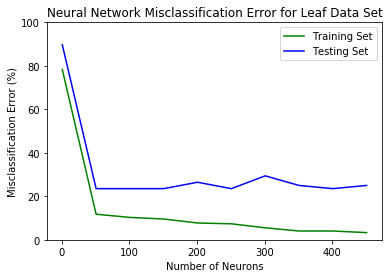

0.25


In [118]:
# determining best number of neurons
optimal_neurons = neurons[test_e.index(min(test_e))]
print("The optimal number of neighbors is %d" % optimal_neurons)

# plot misclassification error vs k
plt.plot(neurons,100*np.array(train_e),'g',label='Training Set')
plt.plot(neurons,100*np.array(test_e),'b',label='Testing Set')
plt.xlabel('Number of Neurons')
plt.ylabel('Misclassification Error (%)')
plt.title('Neural Network Misclassification Error for Leaf Data Set')
plt.ylim([0,100])
plt.legend()
plt.show()

print(test_e[train_e.index(min(train_e))])


# Plotting Results

In [115]:
# determining best number of neurons
optimal_neurons = neurons[test_e.index(min(test_e))]
print("The optimal number of neighbors is %d" % optimal_neurons)

# plot misclassification error vs k
plt.plot(neurons,100*np.array(train_e),'g',label='Training Set')
plt.plot(neurons,100*np.array(test_e),'b',label='Testing Set')
plt.xlabel('Number of Neurons')
plt.ylabel('Misclassification Error (%)')
plt.title('Neural Network Misclassification Error for Leaf Data Set')
plt.ylim([0,100])
plt.legend()
plt.show()

print(test_e[train_e.index(min(train_e))])


ValueError: min() arg is an empty sequence

# Training with best structure

C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\ipykernel_launcher.py:12: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  if sys.path[0] == '':


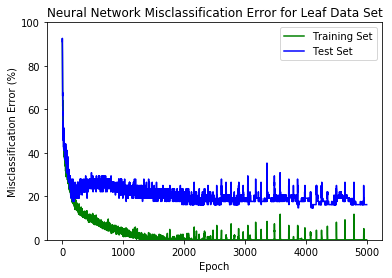

Training Set Misclassification Error is [0.0]
Testing Set Misclassification Error is [0.16176470588235292]


In [122]:
train_all = []
test_all = []

values = random.sample(list(np.arange(0,len(trainX),1)),len(trainX))
trainX_use = trainX[values,:]
trainY_use = trainY[values,:]

model = Sequential()
model.add(Dense(400, input_dim=14, kernel_initializer='normal', activation='relu'))
model.add(Dense(36, kernel_initializer='normal', activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
hist = model.fit(trainX,trainY, nb_epoch=5000, batch_size=10,verbose=0,validation_data=(testX,testY))
plt.plot(100*(1-np.array(hist.history['acc'])),'g')
plt.plot(100*(1-np.array(hist.history['val_acc'])),'b')
plt.title('Neural Network Misclassification Error for Leaf Data Set')
plt.ylabel('Misclassification Error (%)')
plt.xlabel('Epoch')
plt.legend(['Training Set', 'Test Set'])
plt.ylim([0,100])
plt.show()

train_pred_NN = convert_out(model.predict(trainX))
train_all.append(1-Pred_correct(train_pred_NN,trainY_comp))

test_pred_NN = convert_out(model.predict(testX))
test_all.append(1-Pred_correct(test_pred_NN,testY_comp))


print('Training Set Misclassification Error is', train_all)
print('Testing Set Misclassification Error is', test_all)                           

# Improving the results by using a validation set

C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\ipykernel_launcher.py:25: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


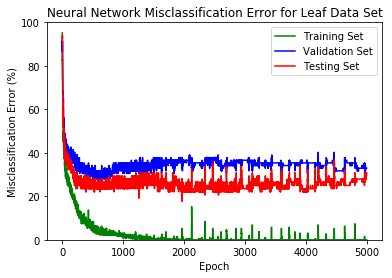

Training Set Misclassification Error is [0.09926470588235292]
Testing Set Misclassification Error is [0.3088235294117647]


In [129]:
class TestCallback(Callback):
    def __init__(self, test_data):
        self.test_data = test_data
    def on_epoch_end(self, epoch, logs):
        x, y = self.test_data
        loss, acc = self.model.evaluate(x, y, verbose=0)
        logs['test_acc'] = acc


train_all = []
test_all = []

values = random.sample(list(np.arange(0,len(trainX),1)),len(trainX))
trainX_use = trainX[values,:]
trainY_use = trainY[values,:]

model = Sequential()
model.add(Dense(500, input_dim=14, kernel_initializer='normal', activation='relu'))
model.add(Dense(36, kernel_initializer='normal', activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# checkpoint
filepath="weights.best_leaf.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, mode='max')
callbacks_list = [checkpoint, TestCallback((testX,testY)),CSVLogger('1.log')]
hist = model.fit(trainX_use,trainY_use, validation_split =0.3, nb_epoch=5000, batch_size=10,verbose=0,callbacks=callbacks_list)
plt.plot(100*np.array(1-np.array(hist.history['acc'])),'g')
plt.plot(100*np.array(1-np.array(hist.history['val_acc'])),'b')
plt.plot(100*np.array(1-np.array(hist.history['test_acc'])),'r')
plt.title('Neural Network Misclassification Error for Leaf Data Set')
plt.ylabel('Misclassification Error (%)')
plt.xlabel('Epoch')
plt.legend(['Training Set', 'Validation Set', 'Testing Set'])
plt.ylim([0,100])
plt.show()

train_pred_NN = convert_out(model.predict(trainX))
train_all.append(1-Pred_correct(train_pred_NN,trainY_comp))

test_pred_NN = convert_out(model.predict(testX))
test_all.append(1-Pred_correct(test_pred_NN,testY_comp))

print('Training Set Misclassification Error is', train_all)
print('Testing Set Misclassification Error is', test_all)    
                            

# Testing the best network structure

In [132]:
model = Sequential()
model.add(Dense(500, input_dim=14, kernel_initializer='normal', activation='relu'))
model.add(Dense(36, kernel_initializer='normal', activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.load_weights("weights.best_leaf.hdf5")

set_val = round(len(values)*0.3)
val_pred = convert_out(model.predict(trainX_use[-set_val:]))
val_act = trainY_comp[values[-set_val:]]
val_acc = (1-Pred_correct(val_pred,val_act))

test_pred = convert_out(model.predict(testX))
test_acc = (1-Pred_correct(test_pred,testY_comp))
print(test_acc)
print(val_acc)



0.25
0.2682926829268293


# Decision Tree with pre pruning

In [6]:
max_depth = np.arange(1,15,1)
min_leaf = np.arange(1,15,1)

train_e_prune = []
test_e_prune = []

parameters = []

for i in range(len(max_depth)):
    for j in range(len(min_leaf)):
        dtree_prune = tree.DecisionTreeClassifier(criterion = "entropy", splitter = 'best',
                                       max_depth=max_depth[i], min_samples_leaf=min_leaf[j])
        dtree_prune.fit(trainX, trainY_comp)
        predict_tree_prune = dtree_prune.predict(trainX)
        train_accuracy = 1-Pred_correct(predict_tree_prune,trainY_comp)
        train_e_prune.append(train_accuracy)

        test_pred_tree_prune= dtree_prune.predict(testX)
        test_accuracy = 1-Pred_correct(test_pred_tree_prune,testY_comp)
        test_e_prune.append(test_accuracy)
        
        parameters.append([max_depth[i],min_leaf[j]])
        
bp = parameters[train_e_prune.index(min(train_e_prune))]
print('Training Set Misclassification is', train_e_prune[train_e_prune.index(min(train_e_prune))])      
print('Testing Set Misclassification is', test_e_prune[train_e_prune.index(min(train_e_prune))])

Training Set Misclassification is 0.0
Testing Set Misclassification is 0.47058823529411764


# Decision tree with best parameters 

In [7]:
train_e_prune = []
test_e_prune = []

dtree_prune_fin = tree.DecisionTreeClassifier(criterion = "entropy", splitter = 'best',
                               max_depth=bp[0], min_samples_leaf=bp[1])
dtree_prune_fin.fit(trainX, trainY_comp)

predict_tree_prune = dtree_prune_fin.predict(trainX)
train_accuracy = 1-Pred_correct(predict_tree_prune,trainY_comp)

test_pred_tree_prune= dtree_prune_fin.predict(testX)
test_accuracy = 1-Pred_correct(test_pred_tree_prune,testY_comp)

print('Training Set Misclassification is', train_accuracy)
print('Testing Set Misclassification is', test_accuracy)

Training Set Misclassification is 0.0
Testing Set Misclassification is 0.4558823529411765


# Decision tree with chaning depth (leaf size constant)

Training Set Misclassification is 0.0
Testing Set Misclassification is 0.4852941176470589


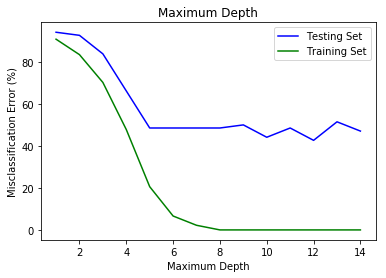

In [8]:
max_depth = np.arange(1,15,1)
min_leaf = np.arange(1,2,1)

train_e_prune = []
test_e_prune = []

parameters = []

for i in range(len(max_depth)):
    for j in range(len(min_leaf)):
        dtree_prune = tree.DecisionTreeClassifier(criterion = "entropy", splitter = 'best',
                                       max_depth=max_depth[i], min_samples_leaf=min_leaf[j])
        dtree_prune.fit(trainX, trainY_comp)

        predict_tree_prune = (dtree_prune.predict(trainX))
        train_accuracy = 1-Pred_correct(predict_tree_prune,trainY_comp)
        train_e_prune.append(train_accuracy)

        test_pred_tree_prune= (dtree_prune.predict(testX))
        test_accuracy = 1-Pred_correct(test_pred_tree_prune,testY_comp)
        test_e_prune.append(test_accuracy)
        
        parameters.append([max_depth[i],min_leaf[j]])
        
print('Training Set Misclassification is', train_e_prune[train_e_prune.index(min(train_e_prune))])      
print('Testing Set Misclassification is', test_e_prune[train_e_prune.index(min(train_e_prune))])

plt.plot(max_depth,100*np.array(test_e_prune),'b',label='Testing Set')
plt.plot(max_depth,100*np.array(train_e_prune),'g',label='Training Set')
plt.xlabel('Maximum Depth')
plt.ylabel('Misclassification Error (%)')
plt.title('Maximum Depth')
plt.legend()
plt.show()


# Decision tree with chaning leaf size

Training Set Misclassification is 0.0
Testing Set Misclassification is 0.4411764705882353


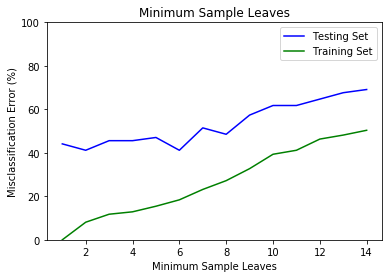

In [9]:
max_depth = np.arange(10,11,1)
min_leaf = np.arange(1,15,1)

train_e_prune = []
test_e_prune = []

parameters = []

for i in range(len(max_depth)):
    for j in range(len(min_leaf)):
        dtree_prune = tree.DecisionTreeClassifier(criterion = "entropy", splitter = 'best',
                                       max_depth=max_depth[i], min_samples_leaf=min_leaf[j])
        dtree_prune.fit(trainX, trainY_comp)

        predict_tree_prune = dtree_prune.predict(trainX)
        train_accuracy = 1-Pred_correct(predict_tree_prune,trainY_comp)
        train_e_prune.append(train_accuracy)

        test_pred_tree_prune= dtree_prune.predict(testX)
        test_accuracy = 1-Pred_correct(test_pred_tree_prune,testY_comp)
        test_e_prune.append(test_accuracy)
        
        parameters.append([max_depth[i],min_leaf[j]])
        
print('Training Set Misclassification is', train_e_prune[train_e_prune.index(min(train_e_prune))])      
print('Testing Set Misclassification is', test_e_prune[train_e_prune.index(min(train_e_prune))])

plt.plot(min_leaf,100*np.array(test_e_prune),'b',label='Testing Set')
plt.plot(min_leaf,100*np.array(train_e_prune),'g',label='Training Set')
plt.xlabel('Minimum Sample Leaves')
plt.ylabel('Misclassification Error (%)')
plt.title('Minimum Sample Leaves')
plt.legend()
plt.ylim([0,100])
plt.show()


# Decision Tree with pre pruning (and changing the train/test split)

0.1
0.2
0.30000000000000004
0.4
0.5
0.6
0.7000000000000001
0.8
0.9
1.0


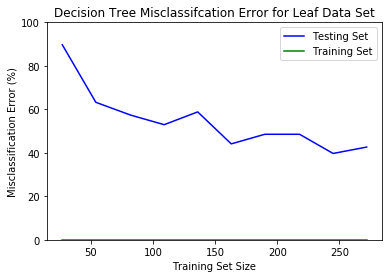

0.0
0.3970588235294118


In [103]:
size = np.arange(0.1,1.01,0.1)

# empty list that will hold cv scores
train_errors = []
test_errors = []
n_all = []

for i in range(len(size)):
    print(size[i])
    
    total_samples = list(np.arange(0,len(trainX),1))
    train_samples = random.sample(total_samples,int(np.round(len(trainX)*size[i])))
    
    trainX_dt,trainY_dt = trainX[train_samples,:], trainY_comp[train_samples]
    testX_dt, testY_dt = testX,testY_comp
    
    n_all.append(len(trainX_dt))
    
    dtree = tree.DecisionTreeClassifier(criterion = "entropy", splitter = 'best',\
                                       max_depth=bp[0], min_samples_leaf=bp[1])
    dtree.fit(trainX_dt,trainY_dt)
    
    predict_tree = dtree.predict(trainX_dt)
    train_accuracy = 1-Pred_correct(predict_tree,np.array(trainY_dt))
    train_errors.append(train_accuracy)

    if len(testX)>0:
        test_pred_tree= dtree.predict(testX_dt)
        test_accuracy = 1-Pred_correct(test_pred_tree,np.array(testY_dt))
        test_errors.append(test_accuracy)
    else:
        test_errors.append(0)
            

        

plt.plot(n_all,100*np.array(test_errors),'b',label='Testing Set')
plt.plot(n_all,100*np.array(train_errors),'g',label='Training Set')
plt.xlabel('Training Set Size')
plt.ylabel('Misclassification Error (%)')
plt.title('Decision Tree Misclassifcation Error for Leaf Data Set')
plt.legend()
plt.ylim([0,100])
plt.show()

print(np.min(train_errors))
print(np.min(test_errors))

# dtree = tree.DecisionTreeClassifier(criterion = "entropy", splitter = 'best')
# dtree.fit(trainX,trainY)

# predict_tree = convert_out(dtree.predict(trainX))
# train_accuracy = Pred_correct(predict_tree,trainY_comp)

# test_pred_tree= convert_out(dtree.predict(testX))
# test_accuracy = Pred_correct(test_pred_tree,testY_comp)

# print(train_accuracy,test_accuracy)

In [104]:
print(bp)

[10, 1]


# Decision Tree with pre pruning and over-sampling (and changing the train/test split)


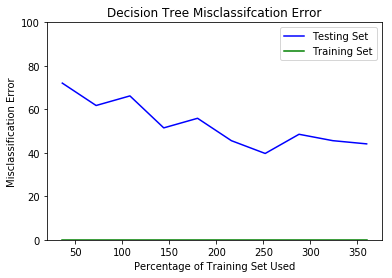

[36, 72, 108, 144, 180, 216, 252, 288, 324, 360]
[0.7205882352941176, 0.6176470588235294, 0.6617647058823529, 0.5147058823529411, 0.5588235294117647, 0.4558823529411765, 0.3970588235294118, 0.4852941176470589, 0.4558823529411765, 0.4411764705882353]


In [82]:
size = np.arange(0.1,1.01,0.1)

# empty list that will hold cv scores
train_errors = []
test_errors = []
n_all = []

ros = RandomOverSampler(random_state=0)
trainX_resampled, trainY_resampled = ros.fit_sample(trainX, trainY_comp)

for i in range(len(size)):
    
    total_samples = list(np.arange(0,len(trainX_resampled),1))
    train_samples = random.sample(total_samples,int(np.round(len(trainX_resampled)*size[i])))

    trainX_dt,trainY_dt = trainX_resampled[train_samples,:], trainY_resampled[train_samples]
#     ros = RandomOverSampler(random_state=0)
#     trainX_dt_resampled, trainY_dt_resampled = ros.fit_sample(trainX_dt, trainY_dt)
    
    n_all.append(np.shape(trainX_dt)[0])

    testX_dt, testY_dt = testX,testY_comp

    dtree = tree.DecisionTreeClassifier(criterion = "entropy", splitter = 'best',\
                                       max_depth=bp[0], min_samples_leaf=bp[1])
    dtree.fit(trainX_dt,trainY_dt)
    
    predict_tree = dtree.predict(trainX_dt)
    train_accuracy = 1-Pred_correct(predict_tree,np.array(trainY_dt))
    train_errors.append(train_accuracy)

    if len(testX)>0:
        test_pred_tree= dtree.predict(testX_dt)
        test_accuracy = 1-Pred_correct(test_pred_tree,np.array(testY_dt))
        test_errors.append(test_accuracy)
    else:
        test_errors.append(0)
            

        

plt.plot(n_all,100*np.array(test_errors),'b',label='Testing Set')
plt.plot(n_all,100*np.array(train_errors),'g',label='Training Set')
plt.xlabel('Percentage of Training Set Used')
plt.ylabel('Misclassification Error')
plt.title('Decision Tree Misclassifcation Error (%)')
plt.legend()
plt.ylim([0,100])
plt.show()

print(n_all)
print(test_errors)

# dtree = tree.DecisionTreeClassifier(criterion = "entropy", splitter = 'best')
# dtree.fit(trainX,trainY)

# predict_tree = convert_out(dtree.predict(trainX))
# train_accuracy = Pred_correct(predict_tree,trainY_comp)

# test_pred_tree= convert_out(dtree.predict(testX))
# test_accuracy = Pred_correct(test_pred_tree,testY_comp)

# print(train_accuracy,test_accuracy)

# Decision Tree with pre pruning and Cross Validation

In [34]:
max_depth = np.arange(1,15,1)
min_leaf = np.arange(1,15,1)

train_e_prune = []
test_e_prune = []

parameters = []

cv_scores = []
n_all = []
test_scores = []
scores_train=[]
count = 1

for i in range(len(max_depth)):
    for j in range(len(min_leaf)):
        n_all.append(count)
        count += 1
        dtree_prune = tree.DecisionTreeClassifier(criterion = "entropy", splitter = 'best',
                                       max_depth=max_depth[i], min_samples_leaf=min_leaf[j])
        #scores = cross_val_score(dtree_prune, trainX, trainY_comp, cv=10, scoring='accuracy')
        scores_all = cross_validate(dtree_prune, trainX, trainY_comp, cv=10, scoring='accuracy')

        cv_scores.append(scores_all["test_score"].mean())
        scores_train.append(scores_all["train_score"].mean())
    

#         test_pred_tree_prune= convert_out(dtree_prune.predict(testX))
#         test_accuracy = 1-Pred_correct(test_pred_tree_prune,testY_comp)
#         test_e_prune.append(test_accuracy)
        parameters.append([max_depth[i],min_leaf[j]])

# changing to misclassification error for training set
MSE_cv_train = [1 - x for x in scores_train]

# changing to misclassification error
MSE_cv = [1 - x for x in cv_scores]

bp_n = parameters[MSE_cv.index(min(MSE_cv))]
print(MSE_cv_train[MSE_cv.index(min(MSE_cv))])      
print(MSE_cv[MSE_cv.index(min(MSE_cv))])
print(bp)

dtree_prune_f = tree.DecisionTreeClassifier(criterion = "entropy", splitter = 'best',
                                       max_depth=bp_n[0], min_samples_leaf=bp_n[1])

dtree_prune_f.fit(trainX, trainY_comp)
test_pred_tree_prune= dtree_prune_f.predict(testX)
test_accuracy = 1-Pred_correct(test_pred_tree_prune,testY_comp)

predict_tree_prune = dtree_prune_f.predict(trainX)
train_accuracy = 1-Pred_correct(predict_tree_prune,trainY_comp)

plt.plot(min_leaf,100*np.array(MSE_cv),'r',label='Validation Set')
plt.plot(min_leaf,100*np.array(MSE_cv_train),'g',label='Training Set')
plt.xlabel('Minimum Sample Leaves')
plt.ylabel('Misclassification Error (%)')
plt.title('Minimum Sample Leaves')
plt.legend()
plt.ylim([0,100])
plt.show()

C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Ma

C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_arg

C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_arg

C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Ma

C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_arg

C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_arg

C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_arg

C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_arg

C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Ma

C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_arg

C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_arg

C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_arg

C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Ma

C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_arg

0.0
0.34837097436


C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_arg

NameError: name 'bp' is not defined

# Decision Tree with pre pruning and Cross Validation (change max depth)

C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Ma

C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_arg

C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Ma

0.0
0.350053585163
Training Set Misclassification is 0.0
Testing Set Misclassification is 0.36764705882352944


C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


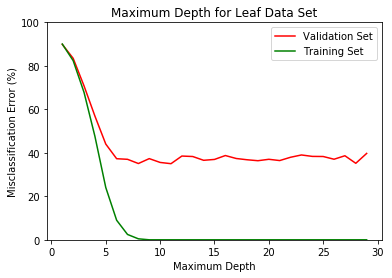

11


In [56]:
max_depth = np.arange(1,30,1)
min_leaf = np.arange(1,2,1)

train_e_prune = []
test_e_prune = []

parameters = []

cv_scores = []
n_all = []
test_scores = []
scores_train=[]
count = 1

for i in range(len(max_depth)):
    for j in range(len(min_leaf)):
        n_all.append(max_depth[i])
        count += 1
        dtree_prune = tree.DecisionTreeClassifier(criterion = "entropy", splitter = 'best',
                                       max_depth=max_depth[i], min_samples_leaf=min_leaf[j])
        #scores = cross_val_score(dtree_prune, trainX, trainY_comp, cv=10, scoring='accuracy')
        scores_all = cross_validate(dtree_prune, trainX, trainY_comp, cv=10, scoring='accuracy')

        cv_scores.append(scores_all["test_score"].mean())
        scores_train.append(scores_all["train_score"].mean())
    

#         test_pred_tree_prune= convert_out(dtree_prune.predict(testX))
#         test_accuracy = 1-Pred_correct(test_pred_tree_prune,testY_comp)
#         test_e_prune.append(test_accuracy)
        parameters.append([max_depth[i],min_leaf[j]])

# changing to misclassification error for training set
MSE_cv_train = [1 - x for x in scores_train]

# changing to misclassification error
MSE_cv = [1 - x for x in cv_scores]

bp_n = n_all[MSE_cv.index(min(MSE_cv))]
print(MSE_cv_train[MSE_cv.index(min(MSE_cv))])      
print(MSE_cv[MSE_cv.index(min(MSE_cv))])

dtree_prune_f = tree.DecisionTreeClassifier(criterion = "entropy", splitter = 'best',
                                       max_depth=bp_n, min_samples_leaf=1)

dtree_prune_f.fit(trainX, trainY_comp)
test_pred_tree_prune= dtree_prune_f.predict(testX)
test_accuracy = 1-Pred_correct(test_pred_tree_prune,testY_comp)

predict_tree_prune = dtree_prune_f.predict(trainX)
train_accuracy = 1-Pred_correct(predict_tree_prune,trainY_comp)

print('Training Set Misclassification is',train_accuracy)
print('Testing Set Misclassification is',test_accuracy)

plt.plot(n_all,100*np.array(MSE_cv),'r',label='Validation Set')
plt.plot(n_all,100*np.array(MSE_cv_train),'g',label='Training Set')
plt.xlabel('Maximum Depth')
plt.ylabel('Misclassification Error (%)')
plt.title('Maximum Depth for Leaf Data Set')
plt.legend()
plt.ylim([0,100])
plt.show()
print(bp_n)

# Decision Tree with pre pruning and Cross Validation (change max depth)


C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Ma

C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Ma

0.0
0.377860229658
Training Set Misclassification is 0.0
Testing Set Misclassification is 0.3088235294117647


C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


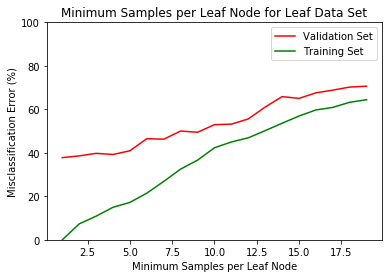

In [43]:
max_depth = np.arange(1,2,1)
min_leaf = np.arange(1,20,1)

train_e_prune = []
test_e_prune = []

parameters = []

cv_scores = []
n_all = []
test_scores = []
scores_train=[]
count = 1

for i in range(len(max_depth)):
    for j in range(len(min_leaf)):
        n_all.append(min_leaf[j])
        count += 1
        dtree_prune = tree.DecisionTreeClassifier(criterion = "entropy", splitter = 'best',
                                       max_depth=bp_n, min_samples_leaf=min_leaf[j])
        #scores = cross_val_score(dtree_prune, trainX, trainY_comp, cv=10, scoring='accuracy')
        scores_all = cross_validate(dtree_prune, trainX, trainY_comp, cv=10, scoring='accuracy')

        cv_scores.append(scores_all["test_score"].mean())
        scores_train.append(scores_all["train_score"].mean())
    

#         test_pred_tree_prune= convert_out(dtree_prune.predict(testX))
#         test_accuracy = 1-Pred_correct(test_pred_tree_prune,testY_comp)
#         test_e_prune.append(test_accuracy)
        parameters.append([max_depth[i],min_leaf[j]])

# changing to misclassification error for training set
MSE_cv_train = [1 - x for x in scores_train]

# changing to misclassification error
MSE_cv = [1 - x for x in cv_scores]

bp_n_2 = n_all[MSE_cv.index(min(MSE_cv))]
print(MSE_cv_train[MSE_cv.index(min(MSE_cv))])      
print(MSE_cv[MSE_cv.index(min(MSE_cv))])

dtree_prune_f = tree.DecisionTreeClassifier(criterion = "entropy", splitter = 'best',
                                       max_depth=bp_n, min_samples_leaf=bp_n_2)

dtree_prune_f.fit(trainX, trainY_comp)
test_pred_tree_prune= dtree_prune_f.predict(testX)
test_accuracy = 1-Pred_correct(test_pred_tree_prune,testY_comp)

predict_tree_prune = dtree_prune_f.predict(trainX)
train_accuracy = 1-Pred_correct(predict_tree_prune,trainY_comp)

print('Training Set Misclassification is',train_accuracy)
print('Testing Set Misclassification is',test_accuracy)

plt.plot(n_all,100*np.array(MSE_cv),'r',label='Validation Set')
plt.plot(n_all,100*np.array(MSE_cv_train),'g',label='Training Set')
plt.xlabel('Minimum Samples per Leaf Node')
plt.ylabel('Misclassification Error (%)')
plt.title('Minimum Samples per Leaf Node for Leaf Data Set')
plt.legend()
plt.ylim([0,100])
plt.show()

# KNN

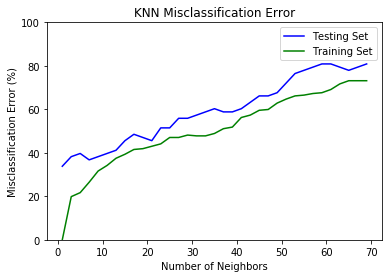

0.0
0.3382352941176471


In [172]:
# creating odd list of K for KNN
myList = list(range(1,70))

# subsetting just the odd ones
#neighbors = np.arange(1,50,1)
neighbors = filter(lambda x: x % 2 != 0, myList)

# empty list that will hold cv scores
train_errors = []
test_errors = []
n_all = []
for k in neighbors:
    n_all.append(k)
    model1 = KNeighborsClassifier(n_neighbors=k,metric='manhattan')

    # Train the model using the training sets
    model1.fit(trainX,trainY_comp)

    predict_knn = model1.predict(trainX)

    train_accuracy = 1-Pred_correct(predict_knn,trainY_comp)

    test_pred_knn= model1.predict(testX)

    test_accuracy = 1-Pred_correct(test_pred_knn,testY_comp)
    
    train_errors.append(train_accuracy)
    test_errors.append(test_accuracy)

plt.plot(n_all,100*np.array(test_errors),'b',label='Testing Set')
plt.plot(n_all,100*np.array(train_errors),'g',label='Training Set')
plt.xlabel('Number of Neighbors')
plt.ylabel('Misclassification Error (%)')
plt.title('KNN Misclassification Error')
plt.ylim([0,100])
plt.legend()
plt.show()

print(train_errors[train_errors.index(min(train_errors))])      
print(test_errors[train_errors.index(min(train_errors))])

# KNN parameter search using Cross Validation

C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 6 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 6 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Ma

C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 6 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_arg

0.6323529411764706
The optimal number of neighbors is 1


C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


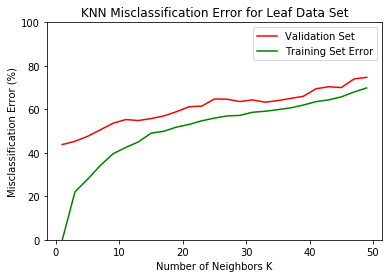

In [173]:
# creating odd list of K for KNN
myList = list(range(1,50))

# subsetting just the odd ones
#neighbors = np.arange(1,50,1)
neighbors = filter(lambda x: x % 2 != 0, myList)

# empty list that will hold cv scores
cv_scores = []
n_all = []
test_scores = []
scores_train=[]
# perform 10-fold cross validation
for k in neighbors:
    n_all.append(k)
    knn = KNeighborsClassifier(n_neighbors=k)
    scores_all = cross_validate(knn, trainX, trainY_comp, cv=10, scoring='accuracy')
    cv_scores.append(scores_all["test_score"].mean())
    scores_train.append(scores_all["train_score"].mean())
    
    model1 = KNeighborsClassifier(n_neighbors=k)
    model1.fit(trainX,trainY_comp)
    test_pred_knn= model1.predict(testX)
    test_accuracy = Pred_correct(test_pred_knn,testY_comp)
    test_scores.append(test_accuracy)

# changing to misclassification error for training set
MSE_cv_train = [1 - x for x in scores_train]

# changing to misclassification error
MSE_cv = [1 - x for x in cv_scores]

# changing to misclassification error for test set
MSE_test = [1 - x for x in test_scores]

print(test_scores[MSE_cv.index(min(MSE_cv))])

# determining best k
optimal_k = n_all[MSE_cv.index(min(MSE_cv))]
print("The optimal number of neighbors is %d" % optimal_k)

# plot misclassification error vs k
plt.plot(n_all, 100*np.array(MSE_cv),'r',label='Validation Set')
#plt.plot(n_all,100*np.array(MSE_test),'b',label='Testing Set')
plt.plot(n_all,100*np.array(MSE_cv_train),'g',label='Training Set Error')
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error (%)')
plt.title('KNN Misclassification Error for Leaf Data Set')

plt.ylim([0,100])
plt.legend()
plt.show()

# Final KNN Model after Cross Validation

In [174]:
model1 = KNeighborsClassifier(n_neighbors=optimal_k)
model1.fit(trainX,trainY_comp)
test_pred_knn= model1.predict(testX)
test_accuracy = 1-Pred_correct(test_pred_knn,testY_comp)

train_accuracy = 1-Pred_correct(model1.predict(trainX),trainY_comp)

print(train_accuracy)
print(test_accuracy)

0.0
0.36764705882352944


# KNN with changing training set size

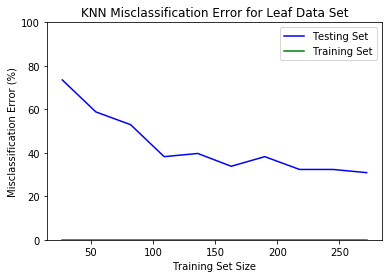

No handles with labels found to put in legend.


0.6911764705882353


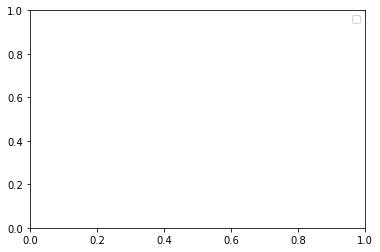

0.2647058823529412
0.6911764705882353


In [69]:
size = np.arange(0.1,1.01,0.1)

# empty list that will hold cv scores
train_errors = []
test_errors = []
n_all = []

for i in range(len(size)):
    n_all.append(size[i])
    
    total_samples = list(np.arange(0,len(trainX),1))
    train_samples = random.sample(total_samples,int(np.round(len(trainX)*size[i])))
    
    trainX_dt,trainY_dt = trainX[train_samples,:], trainY_comp[train_samples]
    testX_dt, testY_dt = testX,testY_comp
    
    #trainX_u, testX_u, trainY_u, testY_u = train_test_split(X, Y, test_size=size[i])

    model1 = KNeighborsClassifier(n_neighbors=optimal_k,metric='manhattan')

    # Train the model using the training sets
    model1.fit(trainX_dt,trainY_dt)

    predict_knn = model1.predict(trainX_dt)
    train_accuracy = Pred_correct(predict_knn,np.array((trainY_dt)))
    train_errors.append(train_accuracy)

    if len(testX)>0:
        test_pred_knn= (model1.predict(testX_dt))

        test_accuracy = Pred_correct(test_pred_knn,np.array((testY_dt)))
        test_errors.append(test_accuracy)
    else:
        test_errors.append(0)
            

        

size = np.arange(0.1,1.01,0.1)

# empty list that will hold cv scores
train_errors = []
test_errors = []
n_all = []

for i in range(len(size)):
   
    
    total_samples = list(np.arange(0,len(trainX),1))
    train_samples = random.sample(total_samples,int(np.round(len(trainX)*size[i])))
    
    trainX_dt,trainY_dt = trainX[train_samples,:], trainY_comp[train_samples]
    testX_dt, testY_dt = testX,testY_comp
    
    n_all.append(np.shape(trainX_dt)[0])
    
    #trainX_u, testX_u, trainY_u, testY_u = train_test_split(X, Y, test_size=size[i])

    model1 = KNeighborsClassifier(n_neighbors=1,metric='manhattan')

    # Train the model using the training sets
    model1.fit(trainX_dt,trainY_dt)

    predict_knn = model1.predict(trainX_dt)
    train_accuracy = Pred_correct(predict_knn,np.array((trainY_dt)))
    train_errors.append(train_accuracy)

    if len(testX)>0:
        test_pred_knn= (model1.predict(testX_dt))

        test_accuracy = Pred_correct(test_pred_knn,np.array((testY_dt)))
        test_errors.append(test_accuracy)
    else:
        test_errors.append(0)
            

        

plt.plot(n_all,100*np.array(1-np.array(test_errors)),'b',label='Testing Set')
plt.plot(n_all,100*np.array(1-np.array(train_errors)),'g',label='Training Set')
plt.xlabel('Training Set Size')
plt.ylabel('Misclassification Error (%)')
plt.title('KNN Misclassification Error for Leaf Data Set')

plt.legend()
plt.ylim([0,100])
plt.show()
print(max(test_errors) )

plt.legend()
plt.ylim([0,1])
plt.show()

print(min(test_errors))
print(max(test_errors))

# KNN with oversampling and changing training size

In [70]:
size = np.arange(0.1,1.01,0.1)

# empty list that will hold cv scores
train_errors = []
test_errors = []
n_all = []

for i in range(len(size)):
    
    total_samples = list(np.arange(0,len(trainX),1))
    train_samples = random.sample(total_samples,int(np.round(len(trainX)*size[i])))
    
    trainX_dt,trainY_dt = trainX[train_samples,:], trainY_comp[train_samples]
    ros = RandomOverSampler(random_state=0)
    trainX_dt_resampled, trainY_dt_resampled = ros.fit_sample(trainX_dt, trainY_dt)
    testX_dt, testY_dt = testX,testY_comp
    
    n_all.append(len(trainX_dt_resampled))
    
    #trainX_u, testX_u, trainY_u, testY_u = train_test_split(X, Y, test_size=size[i])

    model_knn = KNeighborsClassifier(n_neighbors=optimal_k)

    # Train the model using the training sets
    model_knn.fit(trainX_dt_resampled,trainY_dt_resampled)

    predict_knn = model_knn.predict(trainX_dt_resampled)
    train_accuracy = Pred_correct(predict_knn,np.array((trainY_dt_resampled)))
    train_errors.append(train_accuracy)

    if len(testX)>0:
        test_pred_knn= (model_knn.predict(testX_dt))
        test_accuracy = Pred_correct(test_pred_knn,np.array((testY_dt)))
        test_errors.append(test_accuracy)
    else:
        test_errors.append(0)
            

plt.plot(n_all,1-np.array(test_errors),'b',label='Testing Set')
plt.plot(n_all,1-np.array(train_errors),'g',label='Training Set')
plt.xlabel('Percentage of Training Set Used')
plt.ylabel('Misclassification Error')
plt.title('KNN Misclassification Error')

plt.legend()
plt.ylim([0,1])
plt.show()
print(min(test_errors))

NameError: name 'RandomOverSampler' is not defined

# Adaboost for Decision Tree

Training Set Misclassification Error is 0.0
Testing Set Misclassification Error is 0.23529411764705888


Text(0.5,1,'Adaboost Misclassifcation Errors for Leaf Data Set')

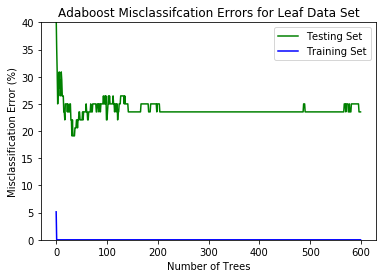

In [180]:
# bdt_real = AdaBoostClassifier(
#     DecisionTreeClassifier(criterion = "entropy", splitter = 'best'),
#     n_estimators=100)

bdt_real = AdaBoostClassifier(DecisionTreeClassifier(max_depth=bp_n, min_samples_leaf=bp_n_2),
    n_estimators=600,learning_rate=1)

bdt_real.fit(trainX,trainY_comp)
predict_tree = bdt_real.predict(trainX)
train_accuracy = Pred_correct(predict_tree,trainY_comp)

test_pred_tree= bdt_real.predict(testX)
test_accuracy = Pred_correct(test_pred_tree,testY_comp)

print('Training Set Misclassification Error is',1-train_accuracy)
print('Testing Set Misclassification Error is',1-test_accuracy)

real_test_errors = []
k = 0
for real_test_predict in zip(bdt_real.staged_predict(testX)):
    real_test_errors.append(1. - Pred_correct(real_test_predict, testY_comp))

r_e = []
for real_train_errors in zip(bdt_real.staged_predict(trainX)):
    r_e.append(1. - Pred_correct(real_train_errors, trainY_comp))


plt.plot(100*np.array(real_test_errors),"g",label='Testing Set')
plt.plot(100*np.array(r_e),'b',label='Training Set')
plt.legend()
plt.ylim([0,40])
plt.ylabel('Misclassification Error (%)')
plt.xlabel('Number of Trees')
plt.title('Adaboost Misclassifcation Errors for Leaf Data Set')


11
1


C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 6 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 6 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Ma

0.36764705882352944
1.0
0.209919098822


(0, 100)

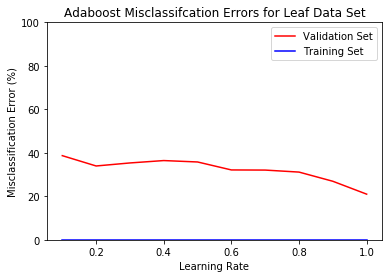

In [178]:
cv_scores = []
scores_train = []
parameters = []


# bdt_real = AdaBoostClassifier(
#     DecisionTreeClassifier(criterion = "entropy", splitter = 'best'),
#     n_estimators=100)
lr = np.arange(0.1,1.01,0.1)
print(bp_n)
print(bp_n_2)
lr_all = []
test_accuracy = []
train_accuracy = []
for i in range(len(lr)):
    lr_all.append(lr[i])
    bdt_real = AdaBoostClassifier(DecisionTreeClassifier(max_depth=bp_n, min_samples_leaf=bp_n_2),
        n_estimators=600,learning_rate=lr[i])
    
    scores_all = cross_validate(bdt_real, trainX, trainY_comp, cv=10, scoring='accuracy')

    cv_scores.append(scores_all["test_score"].mean())
    scores_train.append(scores_all["train_score"].mean())

    bdt_real.fit(trainX,trainY_comp)
    predict_tree = bdt_real.predict(trainX)
    train_accuracy.append(1-Pred_correct(predict_tree,trainY_comp))

    test_pred_tree= bdt_real.predict(testX)
    test_accuracy.append(1-Pred_correct(test_pred_tree,testY_comp))

print(max(test_accuracy))
MSE_cv_train = [1 - x for x in scores_train]

# changing to misclassification error
MSE_cv = [1 - x for x in cv_scores]

print(lr[MSE_cv.index(min(MSE_cv))])      
print(MSE_cv[MSE_cv.index(min(MSE_cv))])

plt.plot(lr_all,100*np.array(MSE_cv),"r",label='Validation Set')
plt.plot(lr_all,100*np.array(MSE_cv_train),'b',label='Training Set')
plt.legend()
plt.ylabel('Misclassification Error (%)')
plt.xlabel('Learning Rate')
plt.title('Adaboost Misclassifcation Errors for Leaf Data Set')
plt.ylim([0,100])

# Normalization

In [153]:
trainX_scaled = X_scaled[train_samples]
trainY = Y[train_samples]
trainY_comp = Y_first[train_samples]

testX_scaled = X_scaled[test_samples]
testY = Y[test_samples]
testY_comp = Y_first[test_samples]

# SVM with changing gamma 

Training Set Misclassification is 0.8088235294117647
Testing Set Misclassification is 0.8970588235294118
[0.10000000000000001]


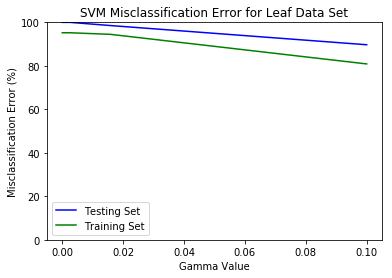

[  1.00000000e-05   6.30957344e-05   3.98107171e-04   2.51188643e-03
   1.58489319e-02   1.00000000e-01]


In [154]:
C_all = np.arange(1,2000,50)
degree_all = np.arange(0,50,1)
gamma_all = np.logspace(-5, -1, 6)

train_all = []
test_all = []
param_all = []

for i in range(len(gamma_all)):
    clf = SVC(gamma = gamma_all[i])
    clf.fit(trainX_scaled, trainY_comp) 
    predict_svm = clf.predict(trainX_scaled)
    train_accuracy = 1-Pred_correct(predict_svm,trainY_comp)
    train_all.append(train_accuracy)

    test_pred_svm= clf.predict(testX_scaled)
    test_accuracy = 1-Pred_correct(test_pred_svm,testY_comp)
    test_all.append(test_accuracy)
    param_all.append([gamma_all[i]])
        

best_gamma = param_all[train_all.index(min(train_all))]
print('Training Set Misclassification is', train_all[train_all.index(min(train_all))])      
print('Testing Set Misclassification is', test_all[train_all.index(min(train_all))])
print(best_gamma)

plt.plot(gamma_all,100*np.array(test_all),'b',label='Testing Set')
plt.plot(gamma_all,100*np.array(train_all),'g',label='Training Set')
plt.xlabel('Gamma Value')
plt.ylabel('Misclassification Error (%)')
plt.title('SVM Misclassification Error for Leaf Data Set')
plt.legend()
plt.ylim([0,100])
plt.show()

print(gamma_all)

# SVM with changing C

Training Set Misclassification is 0.018382352941176516
Testing Set Misclassification is 0.22058823529411764
[1451]


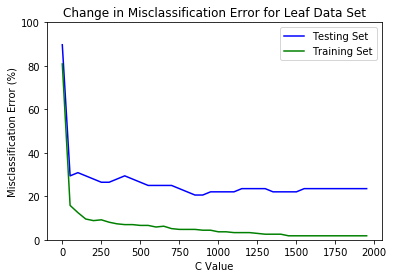

In [155]:
C_all = np.arange(1,2000,50)
degree_all = np.arange(0,50,1)
gamma_all = np.logspace(-6, -1, 5)

train_all = []
test_all = []
param_all = []

for i in range(len(C_all)):
    clf = SVC(C=C_all[i],gamma=float(np.array((best_gamma))))
    clf.fit(trainX_scaled, trainY_comp) 
    predict_svm = clf.predict(trainX_scaled)
    train_accuracy = 1-Pred_correct(predict_svm,trainY_comp)
    train_all.append(train_accuracy)

    test_pred_svm= clf.predict(testX_scaled)
    test_accuracy = 1-Pred_correct(test_pred_svm,testY_comp)
    test_all.append(test_accuracy)
    param_all.append([C_all[i]])
        

best_C = param_all[train_all.index(min(train_all))]
print('Training Set Misclassification is', train_all[train_all.index(min(train_all))])      
print('Testing Set Misclassification is', test_all[train_all.index(min(train_all))])
print(best_C)

plt.plot(C_all,100*np.array(test_all),'b',label='Testing Set')
plt.plot(C_all,100*np.array(train_all),'g',label='Training Set')
plt.xlabel('C Value')
plt.ylabel('Misclassification Error (%)')
plt.title('Change in Misclassification Error for Leaf Data Set')
plt.legend()
plt.ylim([0,100])
plt.show()


# SVM with changing degree


Training Set Misclassification is 0.018382352941176516
Testing Set Misclassification is 0.22058823529411764
[0]


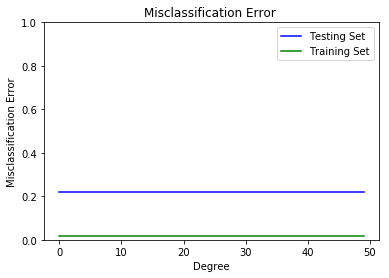

In [156]:
C_all = np.arange(1,2000,50)
degree_all = np.arange(0,50,1)
gamma_all = np.logspace(-6, -1, 5)

train_all = []
test_all = []
param_all = []

for i in range(len(degree_all)):
    clf = SVC(C=float(np.array(best_C)),gamma=float(np.array(best_gamma)),degree=degree_all[i])
    clf.fit(trainX_scaled, trainY_comp) 
    predict_svm = clf.predict(trainX_scaled)
    train_accuracy = 1-Pred_correct(predict_svm,trainY_comp)
    train_all.append(train_accuracy)

    test_pred_svm= clf.predict(testX_scaled)
    test_accuracy = 1-Pred_correct(test_pred_svm,testY_comp)
    test_all.append(test_accuracy)
    param_all.append([degree_all[i]])
        

best_degree = param_all[train_all.index(min(train_all))]
print('Training Set Misclassification is', train_all[train_all.index(min(train_all))])      
print('Testing Set Misclassification is', test_all[train_all.index(min(train_all))])
print(best_degree)

plt.plot(degree_all,test_all,'b',label='Testing Set')
plt.plot(degree_all,train_all,'g',label='Training Set')
plt.xlabel('Degree')
plt.ylabel('Misclassification Error')
plt.title('Misclassification Error ')
plt.legend()
plt.ylim([0,1])
plt.show()


# Changing Degree

Training Set Misclassification is 0.018382352941176516
Testing Set Misclassification is 0.22058823529411764
[0]


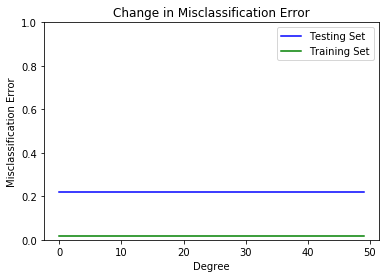

In [157]:
C_all = np.arange(1,2000,50)
degree_all = np.arange(0,50,1)
gamma_all = np.logspace(-6, -1, 5)

train_all = []
test_all = []
param_all = []

for i in range(len(degree_all)):
    clf = SVC(C=float(np.array(best_C)),gamma=float(np.array(best_gamma)),degree=degree_all[i])
    clf.fit(trainX_scaled, trainY_comp) 
    predict_svm = clf.predict(trainX_scaled)
    train_accuracy = 1-Pred_correct(predict_svm,trainY_comp)
    train_all.append(train_accuracy)

    test_pred_svm= clf.predict(testX_scaled)
    test_accuracy = 1-Pred_correct(test_pred_svm,testY_comp)
    test_all.append(test_accuracy)
    param_all.append([degree_all[i]])
        

best_degree = param_all[train_all.index(min(train_all))]
print('Training Set Misclassification is', train_all[train_all.index(min(train_all))])      
print('Testing Set Misclassification is', test_all[train_all.index(min(train_all))])
print(best_degree)

plt.plot(degree_all,test_all,'b',label='Testing Set')
plt.plot(degree_all,train_all,'g',label='Training Set')
plt.xlabel('Degree')
plt.ylabel('Misclassification Error')
plt.title('Change in Misclassification Error')
plt.legend()
plt.ylim([0,1])
plt.show()


# SVM with changing Training Set Size


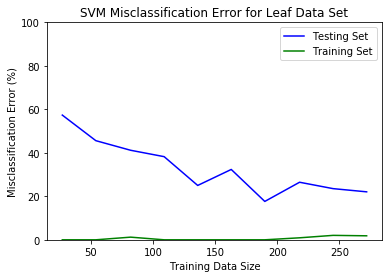

In [167]:
size_u = np.arange(0.1,1.01,0.1)

# empty list that will hold cv scores
test_all = []
train_all = []
n_all = []

for i in range(len(size_u)):
    total_samples = list(np.arange(0,len(trainX),1))
    train_samples = random.sample(total_samples,int(np.round(len(trainX)*size_u[i])))
    
    trainX_dt,trainY_dt = trainX_scaled[train_samples,:], trainY_comp[train_samples]
    testX_dt, testY_dt = testX_scaled,testY_comp
    n_all.append(np.shape(trainX_dt)[0])
    
    clf = SVC(C=float(np.array(best_C)),gamma=float(np.array(best_gamma)),degree=float(np.array(best_degree)))
    clf.fit(trainX_dt, trainY_dt) 
    predict_svm = clf.predict(trainX_dt)
    train_accuracy = 1-Pred_correct(predict_svm,trainY_dt)
    train_all.append(train_accuracy)

    test_pred_svm= clf.predict(testX_dt)
    test_accuracy = 1-Pred_correct(test_pred_svm,testY_comp)
    test_all.append(test_accuracy)

plt.plot(n_all,100*np.array(test_all),'b',label='Testing Set')
plt.plot(n_all,100*np.array(train_all),'g',label='Training Set')
plt.xlabel('Training Data Size')
plt.ylabel('Misclassification Error (%)')
plt.title('SVM Misclassification Error for Leaf Data Set')
plt.legend()
plt.ylim([0,100])
plt.show()


In [165]:
print(test_all)

[0.6323529411764706, 0.47058823529411764, 0.36764705882352944, 0.32352941176470584, 0.3529411764705882, 0.32352941176470584, 0.2941176470588235, 0.25, 0.23529411764705888, 0.22058823529411764]


# SVM with CV (changing C) 

C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 6 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 6 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Ma

C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 6 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_arg

C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 6 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_arg

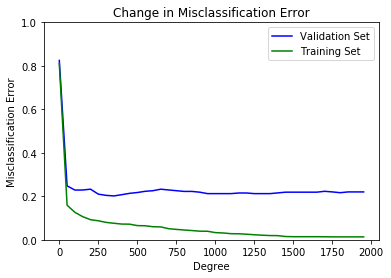

[351]


In [159]:
C_all = np.arange(1,2000,50)
degree_all = np.arange(0,50,1)
gamma_all = np.logspace(-6, -1, 5)

train_all = []
test_all = []
param_all = []

cv_scores = []

scores_train=[]

for i in range(len(C_all)):
    clf_2 = SVC(C=C_all[i],gamma=float(np.array(best_gamma)),degree=float(np.array(best_degree)))
    scores_all = cross_validate(clf_2, trainX_scaled, trainY_comp, cv=10, scoring='accuracy')
    cv_scores.append(1-scores_all["test_score"].mean())
    scores_train.append(1-scores_all["train_score"].mean())
    param_all.append([C_all[i]])
        

best_C_CV = param_all[cv_scores.index(min(cv_scores))]
#print('Training Set Misclassification is', train_all[train_all.index(min(train_all))])      
#print('Testing Set Misclassification is', test_all[train_all.index(min(train_all))])
#print(best_degree)

plt.plot(C_all,np.array(cv_scores),'b',label='Validation Set')
plt.plot(C_all,np.array(scores_train),'g',label='Training Set')
plt.xlabel('Degree')
plt.ylabel('Misclassification Error')
plt.title('Change in Misclassification Error')
plt.legend()
plt.ylim([0,1])
plt.show()

print(best_C_CV)

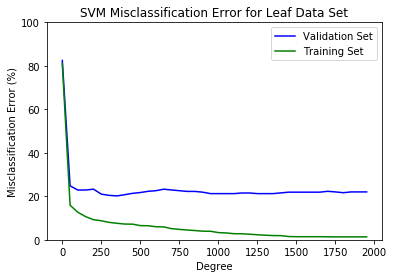

In [161]:
plt.plot(C_all,100*np.array(cv_scores),'b',label='Validation Set')
plt.plot(C_all,100*np.array(scores_train),'g',label='Training Set')
plt.xlabel('Degree')
plt.ylabel('Misclassification Error (%)')
plt.title('SVM Misclassification Error for Leaf Data Set')
plt.legend()
plt.ylim([0,100])
plt.show()


# Final Model

In [184]:
start = timeit.default_timer() 

clf_f = SVC(C=float(np.array(best_C_CV)),gamma=float(np.array(best_gamma)),degree=float(np.array(best_degree)))
clf_f.fit(trainX_scaled, trainY_comp) 
predict_svm = clf_f.predict(trainX_scaled)
train_accuracy = 1-Pred_correct(predict_svm,trainY_comp)

test_pred_svm= clf_f.predict(testX_scaled)
test_accuracy = 1-Pred_correct(test_pred_svm,testY_comp)

best_C_CV = param_all[cv_scores.index(min(cv_scores))]
print('Training Set Misclassification is', train_accuracy)      
print('Testing Set Misclassification is', test_accuracy)

#Your statements here

stop = timeit.default_timer()

print('Time: ', stop - start)

Training Set Misclassification is 0.8088235294117647
Testing Set Misclassification is 0.8970588235294118
Time:  0.03291903450553946
